<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/celeba_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CelebA dataset with pytorch lightning

Based on https://github.com/sayantanauddy/vae_lightning


# Install lightning

In [1]:

! pip install --quiet torchvision pytorch-lightning torchmetrics  torch

     |████████████████████████████████| 819kB 7.6MB/s 
     |████████████████████████████████| 276kB 42.8MB/s 
     |████████████████████████████████| 829kB 40.2MB/s 
     |████████████████████████████████| 645kB 34.9MB/s 
     |████████████████████████████████| 10.6MB 38.5MB/s 
     |████████████████████████████████| 122kB 45.4MB/s 
     |████████████████████████████████| 1.3MB 34.9MB/s 
     |████████████████████████████████| 296kB 45.2MB/s 
     |████████████████████████████████| 143kB 57.9MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [2]:
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


# Getting the data using torchvision.datasets


It is difficult to use [torchvision.datasets.celeba](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.CelebA), as illustrated below.
The reason is that the data is hosted on the authors personal google drive account, so there is a limit to the number of times a bot can download from it.
For details, 
see [this issue](https://github.com/pytorch/vision/issues/2262)
and [this issue](https://github.com/pytorch/vision/issues/1920)).
So you have to download manually.


The needed files for celeba dataset, as defined in the filelist in torchvision's CelebA class, are as follows:
```
img_align_celeba.zip, list_attr_celeba.txt, identity_CelebA.txt, list_bbox_celeba.txt, list_landmarks_align_celeba.txt, list_eval_partition.txt
```
The zip file contains 202,600 .jpg files and is 1.34GB in zip format.

In [29]:
## DO NOT RUN THIS!
from torchvision.datasets import CelebA

dataset = CelebA(root="data-torchvision", split="train", download=True)

RuntimeError: ignored


There are two main solutions: download the data from kaggle, or make a symbolic link to the google drive account and copy locally to colab.

# Kaggle method





## Get API key from Kaggle

Follow [these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get a kaggle.json key file. Then upload it to colab.


In [3]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!ls

kaggle.json  sample_data


In [13]:
!mkdir /root/.kaggle

In [14]:
!cp kaggle.json /root/.kaggle/kaggle.json

In [15]:
!chmod 600 /root/.kaggle/kaggle.json

In [102]:
!rm kaggle.json

## Pytorch dataset and lightning datamodule

This replaces torchvision.datasets.CelebA by downloading from kaggle instead of gdrive.

Code is from https://github.com/sayantanauddy/vae_lightning/blob/main/data.py

In [99]:

!wget -q https://raw.githubusercontent.com/sayantanauddy/vae_lightning/main/data.py

from data import CelebADataset,  CelebADataModule

In [100]:
ds = CelebADataset(root="kaggle", split="test", target_type="attr", download=True)

Files exist already


In [19]:
!ls

kaggle	kaggle.json  sample_data


In [25]:
!ls kaggle

celeba-dataset.zip  list_attr_celeba.csv  list_eval_partition.csv
img_align_celeba    list_bbox_celeba.csv  list_landmarks_align_celeba.csv


In [40]:
# original images are not 64x64
import cv2

fname = "kaggle/img_align_celeba/img_align_celeba/000001.jpg"
img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(218, 178, 3)


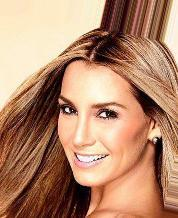

In [41]:
from google.colab.patches import cv2_imshow
import cv2


def show_image(img_path, size=None, ratio=None):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)


show_image(fname)

## Vanilla datamodule

In [101]:
image_size = (64, 64)  # reshape all images to this size
train_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
val_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
target_transform = None

import argparse

parser = argparse.ArgumentParser(description="CelebA")
parser.add_argument("--batch_size", type=int, default=32)  # could be higher?
parser.add_argument("--data_dir", type=str, default="kaggle")  # STORE DATA HERE
parser.add_argument("--target_type", type=str, default="attr")
parser.add_argument("--download", type=bool, default=True)
parser.add_argument("--num_workers", type=int, default=1)  # keep colab happy
# args = parser.parse_args() # error in colab
args, unused = parser.parse_known_args()

# Initialize the DataModule
dm_resize = CelebADataModule(
    data_dir=args.data_dir,
    target_type=args.target_type,
    train_transform=train_transform,
    val_transform=val_transform,
    target_transform=target_transform,
    download=args.download,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
)

In [83]:
dm_resize.prepare_data()  # force download now
dm_resize.setup()  # force make data loaders now

Files exist already


In [84]:
for batch in dm_resize.train_dataloader():
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

# 0..1
print(torch.min(x[0, :, :, :]))
print(torch.max(x[0, 0, :, :]))

torch.Size([32, 3, 64, 64])
torch.Size([32, 40])
tensor(0.0706)
tensor(0.9725)


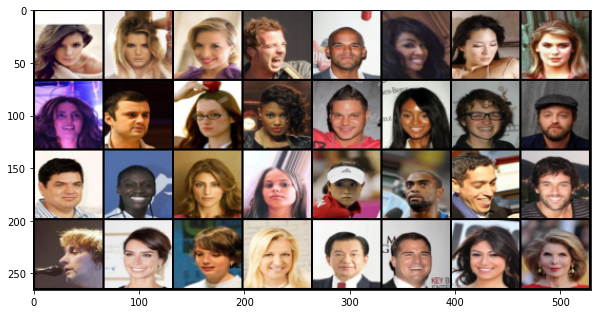

tensor([[0, 0, 1,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 1, 0, 1],
        [0, 1, 1,  ..., 0, 0, 1],
        ...,
        [1, 0, 1,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 0, 1]])


In [85]:
import numpy as np
import matplotlib.pyplot as plt


def imshow(img, unnormalize=False):
    if unnormalize:
        img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dm_resize.train_dataloader())
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images), unnormalize=False)
# show attributes
print(labels)

## Cropping datamodule

https://github.com/AntixK/PyTorch-VAE/blob/master/experiment.py#L135

In [63]:
def data_transforms(img_size=(64, 64)):
    SetRange = transforms.Lambda(lambda X: 2 * X - 1.0)
    SetScale = transforms.Lambda(lambda X: X / X.sum(0).expand_as(X))
    # transforms.RandomHorizontalFlip(),
    transform = transforms.Compose(
        [transforms.CenterCrop(148), transforms.Resize(img_size), transforms.ToTensor(), SetRange]
    )
    return transform


train_transform = data_transforms()
val_transform = data_transforms()
target_transform = None

In [64]:
# Initialize the DataModule
dm_crop = CelebADataModule(
    data_dir=args.data_dir,
    target_type=args.target_type,
    train_transform=train_transform,
    val_transform=val_transform,
    target_transform=target_transform,
    download=args.download,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
)

dm_crop.prepare_data()  # force download now
dm_crop.setup()  # force make data loaders now

Files exist already


In [65]:
for batch in dm_crop.train_dataloader():
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

# -1..1
print(torch.min(x[0, :, :, :]))
print(torch.max(x[0, 0, :, :]))

torch.Size([32, 3, 64, 64])
torch.Size([32, 40])
tensor(-1.)
tensor(0.9765)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


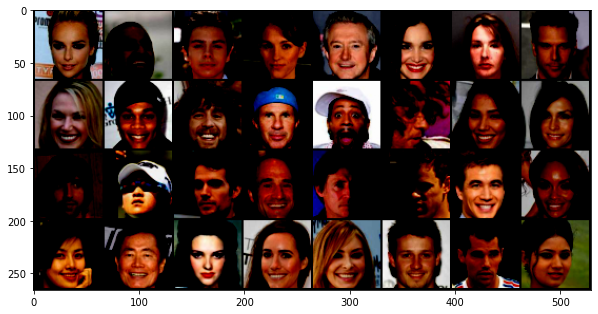

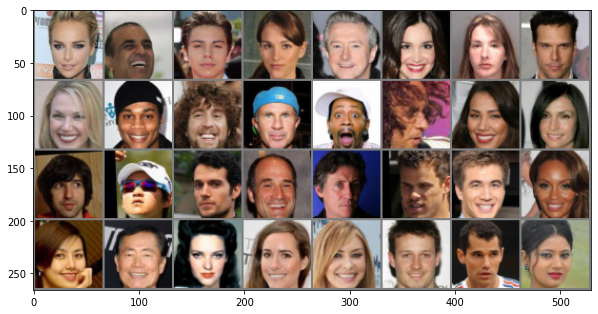

tensor([[0, 1, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 1, 1],
        ...,
        [1, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 1, 1,  ..., 1, 0, 1]])


In [67]:
dataiter = iter(dm_crop.train_dataloader())
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), unnormalize=False)

imshow(torchvision.utils.make_grid(images), unnormalize=True)

print(labels)

# GDrive method

This currently does not work: the data is copied to colab, but the torchvision.dataset.CelebA module cannot read it.

## Mount your google drive

In [44]:
# First mount your google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Make a symbolic link 
Make a symbolic link to the dataset by going to this [link](https://drive.google.com/drive/folders/1ngzl-cI1s-Ib8k_e9LDVZ_eQJRHvXq2V)
and clicking "Add shortcut to drive" here:

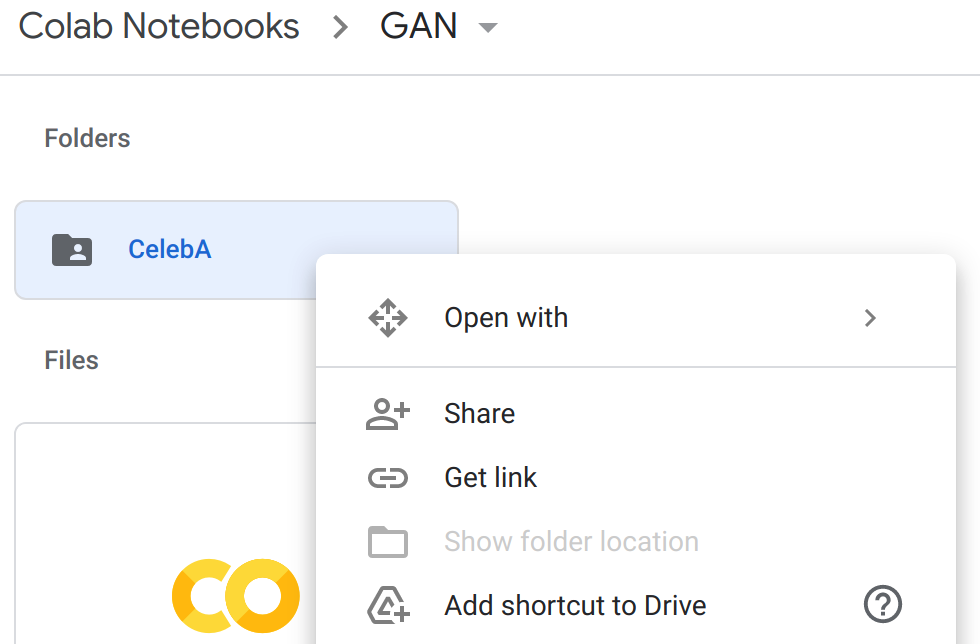

In [45]:
!ls /content/drive/MyDrive/CelebA/

Anno  Eval  Img  README.txt


In [46]:
!ls /content/drive/MyDrive/CelebA/Anno

identity_CelebA.txt   list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [47]:
!head /content/drive/MyDrive/CelebA/README.txt

Large-scale CelebFaces Attributes (CelebA) Dataset

--------------------------------------------------------
By Multimedia Lab, The Chinese University of Hong Kong
--------------------------------------------------------

For more information about the dataset, visit the project website:



## Copy the files from gdrive to the colab machine


In [48]:
# Then copy the files needed to the colab machine
%%time
from tqdm.notebook import tqdm
import pathlib

pathlib.Path("celeba/").mkdir(parents=True, exist_ok=True)
celeba_file_list = [
    "Img/img_align_celeba.zip",
    "Anno/identity_CelebA.txt",
    "Anno/list_attr_celeba.txt",
    "Anno/list_bbox_celeba.txt",
    "Anno/list_landmarks_align_celeba.txt",
    "Eval/list_eval_partition.txt",
]
for file_to_be_copied in tqdm(celeba_file_list, desc="Copying the dataset files"):
    dest = file_to_be_copied.split("/")[1]
    !cp /content/drive/MyDrive/CelebA/$file_to_be_copied celeba/$dest


CPU times: user 421 ms, sys: 196 ms, total: 617 ms
Wall time: 41.4 s


In [49]:
!ls celeba

identity_CelebA.txt   list_attr_celeba.txt  list_eval_partition.txt
img_align_celeba.zip  list_bbox_celeba.txt  list_landmarks_align_celeba.txt


In [50]:
!unzip -q celeba/img_align_celeba.zip

In [69]:
!ls

celeba	drive  img_align_celeba  kaggle  kaggle.json  sample_data


In [70]:
!mv img_align_celeba celeba

In [71]:
!ls celeba

identity_CelebA.txt   list_attr_celeba.txt     list_landmarks_align_celeba.txt
img_align_celeba      list_bbox_celeba.txt
img_align_celeba.zip  list_eval_partition.txt


In [72]:
# original images are not 64x64
fname = "celeba/img_align_celeba/000001.jpg"
img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(218, 178, 3)


In [74]:
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader

ds = CelebA(root="celeba", split="test", download=True)  # fails

RuntimeError: ignored

In [75]:
ds = CelebA(root="celeba", split="test", download=False)  # fails

RuntimeError: ignored

# Image arithmetic

In [86]:
# dm = dm_crop
dm = dm_resize

In [103]:

!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/celeba_helpers.py

from celeba_helpers import compute_average_images, plot_modified_images

## Compute average of images with or without a certain attribute

In [77]:
attr_str = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
attr_list = attr_str.split()
n = len(attr_list)  # 40
attr_dict = dict(zip(attr_list, range(n)))
print(attr_dict)

{'5_o_Clock_Shadow': 0, 'Arched_Eyebrows': 1, 'Attractive': 2, 'Bags_Under_Eyes': 3, 'Bald': 4, 'Bangs': 5, 'Big_Lips': 6, 'Big_Nose': 7, 'Black_Hair': 8, 'Blond_Hair': 9, 'Blurry': 10, 'Brown_Hair': 11, 'Bushy_Eyebrows': 12, 'Chubby': 13, 'Double_Chin': 14, 'Eyeglasses': 15, 'Goatee': 16, 'Gray_Hair': 17, 'Heavy_Makeup': 18, 'High_Cheekbones': 19, 'Male': 20, 'Mouth_Slightly_Open': 21, 'Mustache': 22, 'Narrow_Eyes': 23, 'No_Beard': 24, 'Oval_Face': 25, 'Pale_Skin': 26, 'Pointy_Nose': 27, 'Receding_Hairline': 28, 'Rosy_Cheeks': 29, 'Sideburns': 30, 'Smiling': 31, 'Straight_Hair': 32, 'Wavy_Hair': 33, 'Wearing_Earrings': 34, 'Wearing_Hat': 35, 'Wearing_Lipstick': 36, 'Wearing_Necklace': 37, 'Wearing_Necktie': 38, 'Young': 39}


## Compute average smiling and non-smiling face

In [79]:
smiling_idx = attr_dict["Smiling"]
print(smiling_idx)

31


In [104]:
avg_img_with_feat, avg_img_without_feat = compute_average_images(
    feature_idx=smiling_idx,
    image_dim=(3, 64, 64),
    data_loader=dm.train_dataloader(),
    device=None,
    encoding_fn=None,
    max_batches=50,
)

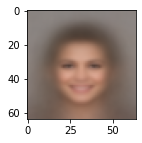

In [88]:
# smiling
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_with_feat).permute(1, 2, 0))
plt.show()

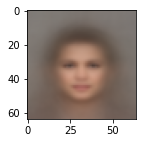

In [89]:
# non-smiling
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_without_feat).permute(1, 2, 0))
plt.show()

## Increase or decrease an attribute

In [91]:
torch.manual_seed(0)
for images, labels in dm.train_dataloader():
    print("Image batch dimensions:", images.size())
    print("Image label dimensions:", labels.size())
    print(labels[:1])
    break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32, 40])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])


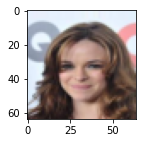

In [92]:
EXAMPLE_IMAGE = images[2]
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(EXAMPLE_IMAGE.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

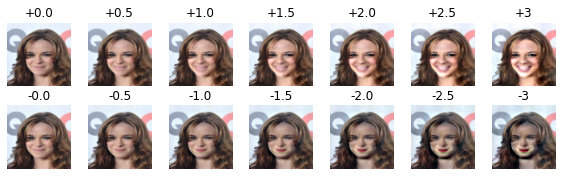

In [105]:
diff = avg_img_with_feat - avg_img_without_feat
plot_modified_images(original=EXAMPLE_IMAGE, diff=diff, diff_coefficients=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3))

plt.tight_layout()
plt.show()